In [1]:
# Load config
from config import UNetTraining
config = UNetTraining.Configuration()

In [2]:
import tensorflow as tf
import numpy as np

import os
import time
import rasterio.warp # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta #, adagrad, adam, nadam

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%run "2_model.ipynb"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

#### Conversion to Tensor

In [6]:
"""X_train_torch = torch.FloatTensor(X_train_reshaped)
y_train_torch = torch.FloatTensor(y_train)

X_test_torch = torch.FloatTensor(X_test_reshaped)
y_test_torch = torch.FloatTensor(y_test)

X_val_torch = torch.FloatTensor(X_val)
y_val_torch = torch.FloatTensor(y_val)

torch_var = [X_train_torch, y_train_torch, X_test_torch, y_test_torch, X_val_torch, y_val_torch]
type(X_train_torch), X_train_torch.shape"""

'X_train_torch = torch.FloatTensor(X_train_reshaped)\ny_train_torch = torch.FloatTensor(y_train)\n\nX_test_torch = torch.FloatTensor(X_test_reshaped)\ny_test_torch = torch.FloatTensor(y_test)\n\nX_val_torch = torch.FloatTensor(X_val)\ny_val_torch = torch.FloatTensor(y_val)\n\ntorch_var = [X_train_torch, y_train_torch, X_test_torch, y_test_torch, X_val_torch, y_val_torch]\ntype(X_train_torch), X_train_torch.shape'

In [7]:
def getType(variables: list):
    for elem in variables:
        print(type(elem), elem.dtype)
        print(elem.shape, elem.shape)

In [8]:
# getType([X_train_reshaped, y_train, shape_input])
# getType([y_train_tensor])
# getType([X_train_torch, y_train_torch, shape_input])
# getType([X_train_tensor, y_train_tensor])

#### Move to GPU

In [9]:
# move model to gpu
# model.device
# model.to(device)
# model.is_cuda
# model_on_gpu = model.cuda()

In [10]:
# Inspect GPU
# torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0)
# tf.test.is_gpu_available(), tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

#### Train & Save Model

##### Notebook

In [11]:
"""train_ds = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test))

print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))"""

'train_ds = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))\nval_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))\ntest_ds = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test))\n\nprint(tf.data.experimental.cardinality(train_ds))\nprint(tf.data.experimental.cardinality(val_ds))\nprint(tf.data.experimental.cardinality(test_ds))'

In [12]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(config.model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

In [13]:
"""SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(config.BATCH_SIZE)
test_dataset = test_ds.batch(config.BATCH_SIZE)
validation_dataset = val_ds.batch(config.BATCH_SIZE)"""

'SHUFFLE_BUFFER_SIZE = 100\n\ntrain_dataset = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(config.BATCH_SIZE)\ntest_dataset = test_ds.batch(config.BATCH_SIZE)\nvalidation_dataset = val_ds.batch(config.BATCH_SIZE)'

In [14]:
# train_ds_reshaped = tf.expand_dims(, axis=0)

In [15]:
# X_train_expanded = np.expand_dims(X_train_reshaped, axis=0)
# y_train_expanded = np.expand_dims(y_train)

In [16]:
# X = tf.convert_to_tensor(X_train_reshaped)
# y = tf.convert_to_tensor(y_train)

In [17]:
# reshape data to fit model
X_train_mini_np = np.array(X_train_mini)
X_train_mini_np.shape
shape = X_train_mini_np.shape
X_train_mini_np = np.reshape(X_train_mini_np, (shape[0], shape[2], shape[3], shape[1]))
X_train_mini_np.shape

(664, 3, 256, 256)

(664, 256, 256, 3)

In [18]:
# reshape data to fit model
X_test_np = np.array(X_test)
X_test_np.shape
shape = X_test_np.shape
X_test_np = np.reshape(X_test_np, (shape[0], shape[2], shape[3], shape[1]))
X_test_np.shape

(208, 3, 256, 256)

(208, 256, 256, 3)

In [19]:
# reshape data to fit model
X_val_np = np.array(X_val)
X_val_np.shape
shape = X_val_np.shape
X_val_np = np.reshape(X_val_np, (shape[0], shape[2], shape[3], shape[1]))
X_val_np.shape

(166, 3, 256, 256)

(166, 256, 256, 3)

In [20]:
X_train_mini_np.shape, np.array(y_train_mini).shape, X_test_np.shape

((664, 256, 256, 3), (664, 256, 256), (208, 256, 256, 3))

In [21]:
%%time
if 1:
    loss_history = model.fit(x=X_train_mini_np, y=np.array(y_train_mini), #train_ds, # train_dataset,
                            epochs=30, # config.NB_EPOCHS, 
                            validation_data=(X_val_np, np.array(y_val)), # validation_dataset,
                            steps_per_epoch=22,#config.MAX_TRAIN_STEPS, # steps_per_epoch * epochs <= # data instances = 94
                            # validation_steps=config.VALID_IMG_COUNT,
                            batch_size=config.BATCH_SIZE,
                            callbacks=callbacks_list
                            # workers=1,
                            # use_multiprocessing=True # the generator is not very thread safe
                    )
"""else:
    loss_history = [model.fit(x=X, y=y,
                            epochs=1, # config.NB_EPOCHS, 
                            validation_data=val_ds,
                            steps_per_epoch=100,#config.MAX_TRAIN_STEPS,
                            # validation_steps=config.VALID_IMG_COUNT,
                            batch_size=config.BATCH_SIZE,
                            callbacks=callbacks_list
                            # workers=1,
                            # use_multiprocessing=True # the generator is not very thread safe
                    )]
"""
print("Training completed.")

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.2764 - dice_coef: 0.0438 - dice_loss: 0.9562 - specificity: 0.1249 - sensitivity: nan - accuracy: 0.1438
Epoch 1: val_loss improved from inf to 0.42768, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 240s 11s/step - loss: 0.2764 - dice_coef: 0.0438 - dice_loss: 0.9562 - specificity: 0.1249 - sensitivity: nan - accuracy: 0.1438 - val_loss: 0.4277 - val_dice_coef: 0.0287 - val_dice_loss: 0.9713 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.3920 - dice_coef: 0.0297 - dice_loss: 0.9703 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0149
Epoch 2: val_loss improved from 0.42768 to 0.39674, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.3920 - dice_coef: 0.0297 - dice_loss: 0.9703 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0149 - val_loss: 0.3967 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.2612 - dice_coef: 0.0298 - dice_loss: 0.9702 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0150
Epoch 3: val_loss improved from 0.39674 to 0.37860, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.2612 - dice_coef: 0.0298 - dice_loss: 0.9702 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0150 - val_loss: 0.3786 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.3934 - dice_coef: 0.0375 - dice_loss: 0.9625 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0188
Epoch 4: val_loss improved from 0.37860 to 0.36639, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 232s 11s/step - loss: 0.3934 - dice_coef: 0.0375 - dice_loss: 0.9625 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0188 - val_loss: 0.3664 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 5/30
22/22 [==============================] - ETA: 0s - loss: 0.2979 - dice_coef: 0.0312 - dice_loss: 0.9688 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0156
Epoch 5: val_loss improved from 0.36639 to 0.36088, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 238s 11s/step - loss: 0.2979 - dice_coef: 0.0312 - dice_loss: 0.9688 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0156 - val_loss: 0.3609 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 6/30
22/22 [==============================] - ETA: 0s - loss: 0.3622 - dice_coef: 0.0348 - dice_loss: 0.9652 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0175
Epoch 6: val_loss improved from 0.36088 to 0.35619, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.3622 - dice_coef: 0.0348 - dice_loss: 0.9652 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0175 - val_loss: 0.3562 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 7/30
22/22 [==============================] - ETA: 0s - loss: 0.2937 - dice_coef: 0.0410 - dice_loss: 0.9590 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0206
Epoch 7: val_loss improved from 0.35619 to 0.35049, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.2937 - dice_coef: 0.0410 - dice_loss: 0.9590 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0206 - val_loss: 0.3505 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 8/30
22/22 [==============================] - ETA: 0s - loss: 0.4471 - dice_coef: 0.0285 - dice_loss: 0.9715 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0143
Epoch 8: val_loss improved from 0.35049 to 0.34541, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.4471 - dice_coef: 0.0285 - dice_loss: 0.9715 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0143 - val_loss: 0.3454 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 9/30
22/22 [==============================] - ETA: 0s - loss: 0.2458 - dice_coef: 0.0464 - dice_loss: 0.9536 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0233
Epoch 9: val_loss improved from 0.34541 to 0.34056, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.2458 - dice_coef: 0.0464 - dice_loss: 0.9536 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0233 - val_loss: 0.3406 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 10/30
22/22 [==============================] - ETA: 0s - loss: 0.4166 - dice_coef: 0.0235 - dice_loss: 0.9765 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0118
Epoch 10: val_loss improved from 0.34056 to 0.33420, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 232s 11s/step - loss: 0.4166 - dice_coef: 0.0235 - dice_loss: 0.9765 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0118 - val_loss: 0.3342 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 11/30
22/22 [==============================] - ETA: 0s - loss: 0.3013 - dice_coef: 0.0428 - dice_loss: 0.9572 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0215
Epoch 11: val_loss improved from 0.33420 to 0.32976, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 238s 11s/step - loss: 0.3013 - dice_coef: 0.0428 - dice_loss: 0.9572 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0215 - val_loss: 0.3298 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 12/30
22/22 [==============================] - ETA: 0s - loss: 0.2536 - dice_coef: 0.0500 - dice_loss: 0.9500 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0251
Epoch 12: val_loss improved from 0.32976 to 0.32254, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.2536 - dice_coef: 0.0500 - dice_loss: 0.9500 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0251 - val_loss: 0.3225 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 13/30
22/22 [==============================] - ETA: 0s - loss: 0.3786 - dice_coef: 0.0269 - dice_loss: 0.9731 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0135
Epoch 13: val_loss improved from 0.32254 to 0.31166, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.3786 - dice_coef: 0.0269 - dice_loss: 0.9731 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0135 - val_loss: 0.3117 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 14/30
22/22 [==============================] - ETA: 0s - loss: 0.2964 - dice_coef: 0.0361 - dice_loss: 0.9639 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0181
Epoch 14: val_loss improved from 0.31166 to 0.30117, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.2964 - dice_coef: 0.0361 - dice_loss: 0.9639 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0181 - val_loss: 0.3012 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 15/30
22/22 [==============================] - ETA: 0s - loss: 0.3533 - dice_coef: 0.0285 - dice_loss: 0.9715 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0143
Epoch 15: val_loss improved from 0.30117 to 0.29219, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.3533 - dice_coef: 0.0285 - dice_loss: 0.9715 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0143 - val_loss: 0.2922 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 16/30
22/22 [==============================] - ETA: 0s - loss: 0.3591 - dice_coef: 0.0396 - dice_loss: 0.9604 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0199
Epoch 16: val_loss improved from 0.29219 to 0.28609, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.3591 - dice_coef: 0.0396 - dice_loss: 0.9604 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0199 - val_loss: 0.2861 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 17/30
22/22 [==============================] - ETA: 0s - loss: 0.2970 - dice_coef: 0.0333 - dice_loss: 0.9667 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0167
Epoch 17: val_loss improved from 0.28609 to 0.28294, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.2970 - dice_coef: 0.0333 - dice_loss: 0.9667 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0167 - val_loss: 0.2829 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 18/30
22/22 [==============================] - ETA: 0s - loss: 0.2156 - dice_coef: 0.0345 - dice_loss: 0.9655 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0173
Epoch 18: val_loss improved from 0.28294 to 0.28175, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 233s 11s/step - loss: 0.2156 - dice_coef: 0.0345 - dice_loss: 0.9655 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0173 - val_loss: 0.2817 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 19/30
22/22 [==============================] - ETA: 0s - loss: 0.3009 - dice_coef: 0.0362 - dice_loss: 0.9638 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0182
Epoch 19: val_loss improved from 0.28175 to 0.28123, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 238s 11s/step - loss: 0.3009 - dice_coef: 0.0362 - dice_loss: 0.9638 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0182 - val_loss: 0.2812 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 20/30
22/22 [==============================] - ETA: 0s - loss: 0.4087 - dice_coef: 0.0372 - dice_loss: 0.9628 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0187
Epoch 20: val_loss did not improve from 0.28123
22/22 [==============================] - 230s 10s/step - loss: 0.4087 - dice_coef: 0.0372 - dice_loss: 0.9628 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0187 - val_loss: 0.2818 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 21/30
22/22 [==============================] - ETA: 0s - loss: 0.1764 - dice_coef: 0.0362 - dice_loss: 0.9638 - specificity: 0.0000e

INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 232s 11s/step - loss: 0.3446 - dice_coef: 0.0288 - dice_loss: 0.9712 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0145 - val_loss: 0.2795 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 28/30
22/22 [==============================] - ETA: 0s - loss: 0.4199 - dice_coef: 0.0321 - dice_loss: 0.9679 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0161
Epoch 28: val_loss improved from 0.27951 to 0.27757, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.4199 - dice_coef: 0.0321 - dice_loss: 0.9679 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0161 - val_loss: 0.2776 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 29/30
22/22 [==============================] - ETA: 0s - loss: 0.1427 - dice_coef: 0.0334 - dice_loss: 0.9666 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0167
Epoch 29: val_loss improved from 0.27757 to 0.27631, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 232s 11s/step - loss: 0.1427 - dice_coef: 0.0334 - dice_loss: 0.9666 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0167 - val_loss: 0.2763 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Epoch 30/30
22/22 [==============================] - ETA: 0s - loss: 0.1628 - dice_coef: 0.0474 - dice_loss: 0.9526 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0238
Epoch 30: val_loss improved from 0.27631 to 0.26947, saving model to /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/assets


22/22 [==============================] - 237s 11s/step - loss: 0.1628 - dice_coef: 0.0474 - dice_loss: 0.9526 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0238 - val_loss: 0.2695 - val_dice_coef: 0.0288 - val_dice_loss: 0.9712 - val_specificity: 0.0000e+00 - val_sensitivity: nan - val_accuracy: 0.0145
Training completed.
CPU times: user 2d 3h 20min 30s, sys: 5h 21min 9s, total: 2d 8h 41min 40s
Wall time: 1h 57min 11s


In [30]:
if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
timestr = time.strftime("%Y%m%d-%H%M")
model_path = os.path.join(config.model_path,'UNet_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,config.input_shape[0]))
model.save(model_path)

'/home/jovyan/work/saved_data/south_africa_tree_stock/saved_models/UNet_20220305-1434_AdaDelta_weightmap_tversky_256.h5'

In [23]:
model.evaluate(x=X_test_np, y=np.array(y_test), batch_size=config.BATCH_SIZE)

13/13 [==============================] - 22s 2s/step - loss: 0.4065 - dice_coef: 0.0318 - dice_loss: 0.9682 - specificity: 0.0000e+00 - sensitivity: nan - accuracy: 0.0160


[0.4064891040325165,
 0.03180185332894325,
 0.9681981801986694,
 0.0,
 nan,
 0.01596304029226303]

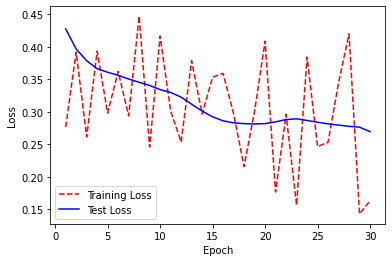

In [25]:
# Get training and test loss histories
training_loss = loss_history.history['loss']
test_loss = loss_history.history['val_loss']
dice_loss = loss_history.history['dice_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();